<h1>Text Summarization by Sentence Scoring and Selection



</h1>


Dorian Erazo




In [ ]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#change current working directory
#%cd /content/drive/MyDrive/Lab
%cd /content/drive/Shareddrives/Aplicacions_Inteligents_per_la_Web/LAB1

/content/drive/Shareddrives/Aplicacions_Inteligents_per_la_Web/LAB1


In [ ]:
#Print path and content of the current directory
!pwd
!ls
#for problem 8:
!pip install rouge

/content/drive/Shareddrives/Aplicacions_Inteligents_per_la_Web/LAB1
 4_data_preparation_training					        LAB-SUMM-2023-INTRO.pdf
 AIW_2023_LAB1_SUMMARIZATION_BY_REGRESSION_STUDENTS.ipynb	        modelo_regresion.h5
'AIW_2023_LAB1_SUMMARIZATION_BY_REGRESSION_STUDENTS_PART_2 (2).ipynb'   processed_data
 AIW_2023_summarizing_DR_INVENTOR.pdf				        stored_data


In [ ]:
#imports
from rouge import Rouge
import nltk
import pickle
import re
import numpy as np
from nltk.corpus import stopwords
from functools import lru_cache
from string import punctuation
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import gensim.downloader as api
import keras
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.layers import Dense, Dropout
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
import xml.etree.ElementTree as ET
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import multiprocessing
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stemmer = nltk.stem.SnowballStemmer('english')
stopwords = set(stopwords.words('english'))

glove_model = api.load("glove-wiki-gigaword-50")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


[==================================================] 100.0% 66.0/66.0MB downloaded


# Preprocessing data

In [ ]:
# TODO: Implement all the above functions
@lru_cache(maxsize=1024)

def is_punctuation(word):
    #return bool(re.match(r'^[!"q#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+$', word))
    return ''.join([char for char in word if char not in punctuation]) == ''

def remove_punctuation(words):
   #return [re.sub(r'[^\w\s]', '', word) for word in words]
    return [word for word in words if not is_punctuation(word)]

def stem_words(words):
    return [stemmer.stem(word) for word in words]

def remove_stopwords(words):
      return [word for word in words if word not in stopwords]

def remove_white_space(text):
    return ' '.join(text.split())

def preprocess(text, lemmatize=True):
    text = text.replace('\\n', '')
    text = re.sub(r'\d+', '', text)  # remove all numbers
    text = remove_white_space(text)
    text = text.lower()
    words = text_to_word_sequence(text)
    words = remove_punctuation(words)
    if lemmatize:
        words = lemmatize_words(words)
    else:
        words = stem_words(words)
    words = remove_stopwords(words)
    return ' '.join(words)

# TODO: (1) Create a function to lemmatize the words. Use the lemmatizer available in nltk
def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

# (2) Modify the "preprocess" function to accept a parameter to indicate if the word has to be lemmatized or stem (only one is possible)
def preprocess(text, lemmatize=True):
    text = text.replace('\\n', '')
    text = re.sub(r'\d+', '', text)  # remove all numbers
    text = remove_white_space(text)
    text = text.lower()
    words = text_to_word_sequence(text)
    words = remove_punctuation(words)
    if lemmatize:
        words = lemmatize_words(words)
    else:
        words = stem_words(words)
    words = remove_stopwords(words)
    return ' '.join(words)



preprocess("Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice 'without pictures or conversation?'")


"alice wa beginning get tired sitting sister bank nothing twice peeped book sister wa reading picture conversation 'and use book thought alice 'without picture conversation"

In [ ]:
def normalize_value(val, min=1.0, max=5.0):
    # normalize value to between 0.0 and 1.0
    return (val - min) / (max - min)


In [ ]:
import pickle

# write list to binary file
def write_list(a_list,file_name):
    # store list in binary file so 'wb' mode
    with open(file_name, 'wb') as fp:
        pickle.dump(a_list, fp)
        print('Done writing list into a binary file')

# Read list to memory
def read_list(file_name):
    # for reading also binary mode is important
    with open(file_name, 'rb') as fp:
        n_list = pickle.load(fp)
        print(n_list)
        return n_list

In [ ]:
my_new_docs=[]
for i in range(40):
  if i<=8:
    fname='processed_data/DR_INVENTOR_A0'+str(i+1)+".pickle"
  else:
    fname='processed_data/DR_INVENTOR_A'+str(i+1)+".pickle"
  my_new_doc=read_list(fname)
  my_new_docs.append(my_new_doc)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# explore the data you get
# check what types of tags are there
# check other features and values
# print a few elements of a document to understand the tags etc. Ask if you need help.

for i in range(1):
  for j in range(1):

    print(my_new_docs[i][j])

{'id': 0, 'tag': 'Document', 'original': '\n\n\n  \n    878f0362cc6e7ed58f87ebe9655631d71db7b8522fb61a35b3a24df1c8fec64a\n    3ww8\n    http://dx.doi.org/10.1515/libr.2002.169\n  \n  \n    \n      \n        ', 'text': '878f0362cc6e7ed58f87ebe9655631d71db7b8522fb61a35b3a24df1c8fec64a 3ww8 http://dx.doi.org/10.1515/libr.2002.169', 'drinv_id': 'A01'}


# Load and split the files for training, validation, and testing.

In [ ]:
# TODO: implement the below functions which take a document (a list as above)
import operator
# return the title of the document
def get_title(doc):
    return doc[1].get("text")

# returns the list of sentences in the abstract
def get_abstract_sentences(doc):
    absSentences = []
    for i in range(len(doc)):
      if doc[i].get("inAbstract") == True:
        absSentences.append(doc[i].get("original"))
    return  absSentences

# returns the list of sentence in the document which are NOT in the abstract
def get_content(doc):
    conSentences = []
    for i in range(len(doc)):
      if doc[i].get("tag") == "Sentence" and doc[i].get("inAbstract") == False:
        conSentences.append(doc[i])
    return  conSentences

# returns a list of sentences (in the content) which are considered more relevant (according to the score they have)
def get_summary(doc, percentage=0.05):
    '''
        Take a certain percentage of sentences sorted by relevance score as a summary
    '''
    content_elements = get_content(doc)
    sorted_elements =  sorted(content_elements, key=lambda x: x['score'], reverse=True)

    size = int(len(content_elements) * percentage)
    summary_elements =  sorted_elements[0:size]
    sorted_summary_elements = sorted(summary_elements,key=lambda x: x['id'], reverse=False)# need to reorder the sentences back in order usiong for example 'id'

    return sorted_summary_elements

def get_summary_content(summary):
    absSentences = []
    for i in range(len(summary)):
      absSentences.append(summary[i].get("original"))
    return  absSentences

# check that its workd

doc = my_new_docs[35]

print("Title: ", get_title(doc))
sents = get_abstract_sentences(doc)
print("_"*100)
print("Abstract: ")
for sent in sents:
    print(sent)

print("_"*100)
print("Summary: ")

for element in get_summary(doc):
    print(element)

Title:  data-driven estimation of cloth simulation models
____________________________________________________________________________________________________
Abstract: 
Progress in cloth simulation for computer animation and apparel design has led to a multitude of deformation models, each with its own way of relating geometry, deformation, and forces.
As simulators improve, differences between these models become more important, but it is difficult to choose a model and a set of parameters to match a given real material simply by looking at simulation results.
This paper provides measurement and fitting methods that allow nonlinear models to be fit to the observed deformation of a particular cloth sample.
Unlike standard textile testing, our system measures complex 3D deformations of a sheet of cloth, not just one-dimensional force–displacement curves, so it works under a wider range of deformation conditions.
The fitted models are then evaluated by comparison to measured deformation

In [ ]:
train_docs =  my_new_docs[:30] # 30 files for training
valid_docs = my_new_docs[30:35] # 5 files for development
test_docs  = my_new_docs[35:] # 5 files for testing

In [ ]:
# TODO: implement the following functions
from numpy import dot
from numpy.linalg import norm
# from sklearn.metrics.pairwise import cosine_similarity

# implement cosine similarity between two vectors
def cosine_similarity(a, b):
    return np.dot(a,b)/(norm(a)*norm(b))

# check if the tokens of sentences are in the WordEmbedding model
def has_representation(sentence):
    '''
        Check whether the sentence has vector representation.
        Check if at least one word of the sentence exists in the language model.
    '''
    words = word_tokenize(sentence)
    return len([word for word in words if word in glove_model]) > 0


# compute the average of Embeddings of the sentence
def mean_words_vector(sentence):
    '''
        Compute the mean of words vector
    '''
    words = word_tokenize(sentence) # tokenize sentence

    words =  [word for word in words if word in glove_model]# remove unknown words (in embedding model)
    if len(words) == 0:
        words =  ['unk']# if empty, use unknown word
    total = 0
    for word in words:
      total+=glove_model.get_vector(word)
    total/= len(words)

    return total

# test that all works
doc = train_docs[0]
title = get_title(doc)
title_vec = mean_words_vector(title)
abstract_sentences = get_abstract_sentences(doc)
abstract_sentences_vec = np.mean([mean_words_vector(sent) for sent in abstract_sentences], axis=0)
print('Title:', title)
print(title_vec)

print("_"*100)
print('Abstract:', abstract_sentences)
print(abstract_sentences_vec)

print("_"*100)
print(has_representation('hello world'))
print(has_representation('   '))

Title: a powell optimization approach for example-based skinning in a production animation environment
[ 3.37384999e-01 -1.72504559e-01 -3.66113007e-01  1.30030096e-01
  1.75844178e-01  3.19821566e-01 -3.08205724e-01 -6.90582633e-01
  1.68288469e-01  2.08326101e-01  1.03160746e-01  7.24736135e-03
 -2.65614539e-01  2.75182843e-01  9.29182693e-02 -5.14745712e-03
  2.88041621e-01  2.98049748e-01 -2.46888176e-01 -3.25453818e-01
  2.95152634e-01  1.44334540e-01 -2.14209184e-01 -1.34141818e-01
  2.24296525e-01 -9.21172142e-01 -1.41327903e-01  9.51798186e-02
  7.03018159e-02  9.78103578e-02  2.74152732e+00 -2.60909528e-01
 -2.71669418e-01 -3.95950288e-01  2.11315812e-03  1.71399534e-01
  1.31473783e-02  4.14288163e-01 -5.09777404e-02 -1.58491090e-01
 -8.60537291e-02  5.02442569e-02 -1.52454436e-01 -1.07227705e-01
  3.34134996e-02 -8.11372790e-03  2.98337489e-01  1.72464788e-01
  1.40820920e-01  3.24177265e-01]
___________________________________________________________________________________

# Features extraction

Each sentence is transformed into an embedding vector contraining: [sentence_vec , title_similarity , abstract_similarity, tf_idf, position]
* <b>sentence_vec</b> is the average word embedding of all words in a sentence.
* <b>title_similary</b> is the cosine similarity between <b>sentence_vec</b> and the average of word embedding of all words in the title.
* <b>abstract_similarity</b> is the cosine similarity beteween <b>sentence_vec</b> and <b>abstract_vec</b>. <b>abstract_vec</b> is the average <b>sentence_vec</b> of all sentences in the abstract.
* <b> tf_idf </b> is an aggregation of tf * idf of the words in the sentence
* <b> position </b> is the "relative"position of sentence in document: the closer to thes start of the document the higher the number

In [ ]:
# TODO: develop the code below

"""
se crea un corpus concatenado a las frases del nuestros documentos
Matriz TF-IDF
Con esto vectorizamos y transformamos el texto en representacion numerica.

"""

# create a corpus for your dataset
# to compute tfidf for the whole corpus
corpus = []
for doc in my_new_docs:
    corpus.append(' '.join([element['text'] for element in doc]))
tf_idf_vect = TfidfVectorizer()  # create a TfIdf vectorizer
tf_idf_model = tf_idf_vect.fit_transform(corpus)  # fit it to the corpus
#features = tf_idf_model.get_feature_names()

def extract_scores(docs):
    y = []
    for doc in docs:
        for element in get_content(doc):
            y.append(element['score'])
    return np.array(y)

#Similar to the function we created earlier, but this time more adjusted to GloVe.
def mean_words_vector(text):
    words = preprocess(text).split()
    vectors = [glove_model[word] for word in words if word in glove_model.key_to_index]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        #if no words are in the GloVe model, return the vector for 'unk' token
        return glove_model['unk']

"""
Esta funcion se encargara de tomar una lista de documentos y extraer caracteristicas para cada frase.
Obtenemos sus vectores de palabra promedio para el tittle y las oraciones resumen.
Recorremos las frases en cada doc y para cada una de ellas:
-obtenemos vector de palabras promedio.
-calculamos similitud cosenos entre frase y titulo
-modelo tf-idf para calcular las caracteristicas
-psocion relativa de la frase en el doc
-todos los valores se concatenan para formar un vector de caracteristicas (frase)
se agregan estos vectores a la lista X y las puntiaciones a Y
"""
def extract_features(docs):
    X, y = [], []
    for doc in tqdm(docs):

        # IMPORTANT NOTE: you should use the preprocess function you have implemented before you compute anything related to text

        title = get_title(doc)  # get title
        title_vec = mean_words_vector(title)  # get the embedding for the title
        abstract_sentences = get_abstract_sentences(doc)  # get the sentences of the abstract
        abstract_sentences_vec = np.mean([mean_words_vector(sent) for sent in abstract_sentences], axis=0)

        for index, element in enumerate(get_content(doc)):
          sentence = element['text']
          sentence_vec = mean_words_vector(sentence)  # get the embedding vector for sentence
          title_similarity = cosine_similarity(sentence_vec, title_vec)  # sentence similarity to the title using cosine
          abstract_similarity = cosine_similarity(sentence_vec, abstract_sentences_vec) # sentence similarity to the abstract using cosine

          # computing TFIDF feature for each sentence
          tfidf = tf_idf_vect.transform([preprocess(sentence)]).toarray()[0]
          tfidf = np.mean(tfidf)  # get one number

          # compute position features
          pos = 1 / (index + 1)  # position of each sentence in the paper, e.g., 1/1, 1/2, 1/3, .. , 1/sizeof(doc)

          sentence_vec = np.append(sentence_vec, [title_similarity, abstract_similarity, tfidf, pos])
          # append the embedding vector with the four features you have computed: title sim, abs sim, tfidf, pos

          X.append(sentence_vec)
          y.append(element['score'])

    return np.array(X)

X_train, y_train = extract_features(train_docs), extract_scores(train_docs)
X_valid, y_valid = extract_features(valid_docs), extract_scores(valid_docs)
X_test, y_test = extract_features(test_docs), extract_scores(test_docs)


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


In [ ]:
# how to save data for next session (CAREFUL OUTOUT  DIRECTORY)
from pathlib  import Path
drive.mount('/content/drive')


my_path= str(Path.cwd())

np.save(my_path+'/stored_data/X_train',X_train)

np.save(my_path+'/stored_data/Y_train',y_train)

np.save(my_path+'/stored_data/X_val',X_valid)

np.save(my_path+'/stored_data/Y_val',y_valid)

np.save(my_path+'/stored_data/X_test',X_test)

np.save(my_path+'/stored_data/Y_test',y_test)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
index = 1
print('Shape:', X_test.shape)
print(f'X_train[{index}]: ', X_test[index])
print(f'y_train[{index}]: ', y_test[index])

Shape: (1272, 54)
X_train[1]:  [ 8.40566307e-02 -9.53088105e-02 -6.08470067e-02 -1.94585904e-01
  2.51279354e-01  3.52265239e-01  3.05239975e-01 -3.86291862e-01
  1.90477550e-01 -1.43515274e-01  6.04177117e-01  2.87209004e-01
 -3.61202518e-03  3.50461751e-02 -7.56801143e-02  4.78740603e-01
  1.33567274e-01  3.15057069e-01  2.71588802e-01 -7.26453602e-01
 -3.92524414e-02 -8.76947269e-02 -5.96590899e-02 -1.66982889e-01
  2.98895240e-01 -6.47675157e-01 -3.32668811e-01 -1.11293634e-02
  5.40526569e-01  1.37633085e-01  2.25003910e+00  1.66678190e-01
 -3.34438235e-01 -5.01453400e-01 -5.77171892e-02  2.77517080e-01
  1.00081824e-01  2.21368641e-01 -2.72861183e-01 -7.66028240e-02
  5.11757247e-02 -2.72925138e-01  1.11171722e-01  2.29568183e-01
 -1.65546536e-01  3.65078114e-02  2.42423922e-01  1.32415116e-01
 -2.39675105e-01  5.43245412e-02  8.12120438e-01  9.29470360e-01
  3.55306411e-04  5.00000000e-01]
y_train[1]:  0.16749999999999998


# **3. Network Implementation**
Implement your network following the architecture of Seminar 4 (following the
first session of this Lab) but adapt it to the regression problem. This adaptation should have only one output in the last layer which is the score to predict. Compile the network using appropriate loss and evaluation functions during training.

In [ ]:
"""
Recordar que no necesitamos una splitting data. En el problema anterior ya hicimos
la extraccion con lo de:
X_train, y_train...

Remember that we do not need a splitting data. In the previous problem we already did
the extraction with the:
X_train, y_train....
"""

#Definimos la arquitectura de la network pero para la regresion:
#creamos un modelo secuencual para las capas de la network. (las capas van apiladas)
model_regression = models.Sequential()
#primera capa de 64 neuronas
model_regression.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
#capa dropout con tasa de 0.5 (prevee sobreajuste) apaga el 50% de neuronas para evitar la
#dependencia de las neuronas, asi evitamos la dependencia excesiva
model_regression.add(layers.Dropout(0.5))
#capa de 16 unidades (es mejor que 32 para evitar el overfitting)
model_regression.add(layers.Dense(32, activation='relu'))
#Capa de salida, solo hay 1 unidad ya que estamos haciendo regresion con activacion lineal
model_regression.add(layers.Dense(1))

#compilar la red para regresión
model_regression.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])


# Resumen del modelo
model_regression.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3520      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5633 (22.00 KB)
Trainable params: 5633 (22.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#4. Data Preparation for Training

Prepare training (30 documents), validation (5 documents), and test (5 documents) data and compute features. Implement functions to save your data to a folder in your drive

In [ ]:
import os
import shutil

drive.mount('/content/drive')
data_dir = '/content/drive/Shareddrives/Aplicacions_Inteligents_per_la_Web/LAB1/4_data_preparation_training'

#creamos las carpetas mediante os:
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

#Limitamos la cantidad de datos a lo que se nos pide
X_train = X_train[:30]
y_train = y_train[:30]
X_valid = X_valid[:5]
y_valid = y_valid[:5]
X_test = X_test[:5]
y_test = y_test[:5]

# Guardar los datos en archivos npy y organizarlos en carpetas
np.save(os.path.join(train_dir, 'X_train.npy'), X_train)
np.save(os.path.join(train_dir, 'y_train.npy'), y_train)
np.save(os.path.join(valid_dir, 'X_valid.npy'), X_valid)
np.save(os.path.join(valid_dir, 'y_valid.npy'), y_valid)
np.save(os.path.join(test_dir, 'X_test.npy'), X_test)
np.save(os.path.join(test_dir, 'y_test.npy'), y_test)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#5. Training and Results
Train your model for several epochs using the training data and checking on validation data. Print the training history to verify any overfitting.

In [ ]:
data_dir = '/content/drive/Shareddrives/Aplicacions_Inteligents_per_la_Web/LAB1/4_data_preparation_training/'

# Cargar datos de entrenamiento, validación y prueba
X_train = np.load(os.path.join(data_dir, 'train/X_train.npy'))
y_train = np.load(os.path.join(data_dir, 'train/y_train.npy'))
X_valid = np.load(os.path.join(data_dir, 'valid/X_valid.npy'))
y_valid = np.load(os.path.join(data_dir, 'valid/y_valid.npy'))
X_test = np.load(os.path.join(data_dir, 'test/X_test.npy'))
y_test = np.load(os.path.join(data_dir, 'test/y_test.npy'))

#modelo a entrenar (50 epochs originalmente)
history = model_regression.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))
#history = model_regression.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_valid, y_valid))
#history = model_regression.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)


print(history.history)


Epoch 1/50
1/1 [==============================] - 7s 7s/step - loss: 0.3187 - mse: 0.3187 - mae: 0.4566 - val_loss: 0.1133 - val_mse: 0.1133 - val_mae: 0.2601
Epoch 2/50
1/1 [==============================] - 0s 55ms/step - loss: 0.2131 - mse: 0.2131 - mae: 0.3752 - val_loss: 0.0855 - val_mse: 0.0855 - val_mae: 0.2084
Epoch 3/50
1/1 [==============================] - 0s 35ms/step - loss: 0.1462 - mse: 0.1462 - mae: 0.2933 - val_loss: 0.0663 - val_mse: 0.0663 - val_mae: 0.1772
Epoch 4/50
1/1 [==============================] - 0s 53ms/step - loss: 0.1149 - mse: 0.1149 - mae: 0.2746 - val_loss: 0.0555 - val_mse: 0.0555 - val_mae: 0.1876
Epoch 5/50
1/1 [==============================] - 0s 52ms/step - loss: 0.1213 - mse: 0.1213 - mae: 0.2647 - val_loss: 0.0506 - val_mse: 0.0506 - val_mae: 0.1983
Epoch 6/50
1/1 [==============================] - 0s 59ms/step - loss: 0.1300 - mse: 0.1300 - mae: 0.2598 - val_loss: 0.0493 - val_mse: 0.0493 - val_mae: 0.2058
Epoch 7/50
1/1 [====================

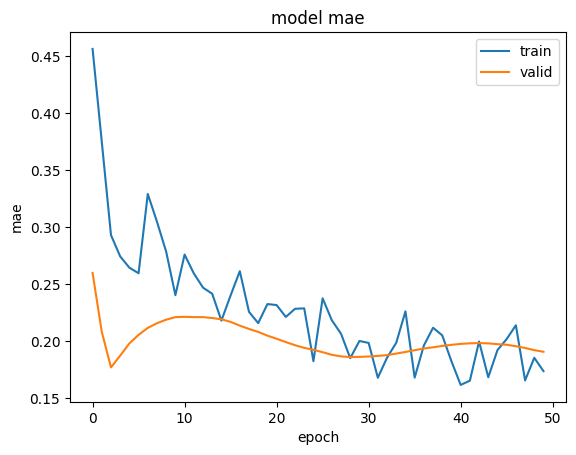

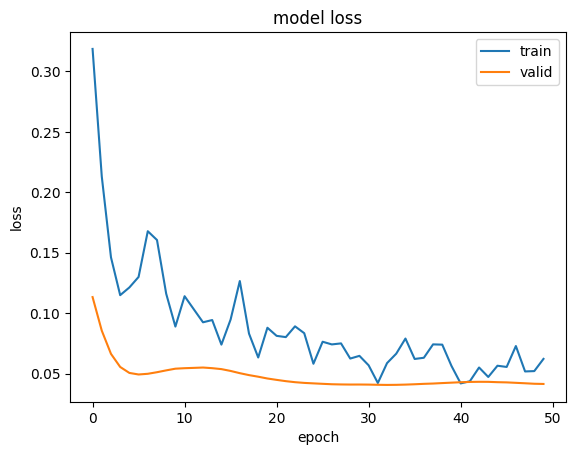

In [ ]:
# summarize history for accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
index = 1
print('Shape:', X_test.shape)
print(f'X_train[{index}]: ', X_test[index])
print(f'y_train[{index}]: ', y_test[index])

Shape: (5, 54)
X_train[1]:  [ 8.40566307e-02 -9.53088105e-02 -6.08470067e-02 -1.94585904e-01
  2.51279354e-01  3.52265239e-01  3.05239975e-01 -3.86291862e-01
  1.90477550e-01 -1.43515274e-01  6.04177117e-01  2.87209004e-01
 -3.61202518e-03  3.50461751e-02 -7.56801143e-02  4.78740603e-01
  1.33567274e-01  3.15057069e-01  2.71588802e-01 -7.26453602e-01
 -3.92524414e-02 -8.76947269e-02 -5.96590899e-02 -1.66982889e-01
  2.98895240e-01 -6.47675157e-01 -3.32668811e-01 -1.11293634e-02
  5.40526569e-01  1.37633085e-01  2.25003910e+00  1.66678190e-01
 -3.34438235e-01 -5.01453400e-01 -5.77171892e-02  2.77517080e-01
  1.00081824e-01  2.21368641e-01 -2.72861183e-01 -7.66028240e-02
  5.11757247e-02 -2.72925138e-01  1.11171722e-01  2.29568183e-01
 -1.65546536e-01  3.65078114e-02  2.42423922e-01  1.32415116e-01
 -2.39675105e-01  5.43245412e-02  8.12120438e-01  9.29470360e-01
  3.55306411e-04  5.00000000e-01]
y_train[1]:  0.16749999999999998


In [ ]:
results = model.evaluate(X_test, y_test)
print("_"*100)
print("loss and mae:", results)

print(len(X_test))
predicted = model.predict(X_test)
print(predicted)

NameError: ignored

#6. Saving Models
Write code to save your model so that it can be used in standalone mode in another Notebook with the saved test data.

In [ ]:
model_regression.save('/content/drive/Shareddrives/Aplicacions_Inteligents_per_la_Web/LAB1/modelo_regresion.h5')

#7. Summarization Application
Write code to load the model and test it with the test data to see the generated
summaries. The application could, for example, present the list of documents
available for summarization showing their titles, and the user should select the
document to summarize using the desired compression which the user should
specify. The system will display the summary in the console.

In [ ]:
model_path = '/content/drive/Shareddrives/Aplicacions_Inteligents_per_la_Web/LAB1/modelo_regresion.h5'
models.load_model(model_path)

for i, doc in enumerate(my_new_docs):
  print(f'{i + 1 }. {get_title(doc)}')

num_documents = len(my_new_docs)
choice = int(input(f"Select a document (1-{num_documents}): "))
while choice < 1 or choice > num_documents:
    choice = int(input(f"Invalid choice. Please select a document (1-{num_documents}): "))

compression_rate = float(input(f"Select a compression rate from 0 to 1"))

while compression_rate < 0 or compression_rate > 1:
  compression_rate = float(input(f"Invalid choice. Please select a compression rate from 0 to 1"))


summary = get_summary(my_new_docs[choice], compression_rate)


print('.\n'.join(get_summary_content(summary)))


#8. Evaluating your Summaries
The summaries produced for your test data will be evaluated using the ROUGE
package. You will report several averaged ROUGE F values (rouge-1, rouge-2)
when comparing your automatic summary with the (3) Human generated
summaries available in Dr Inventor.

In [ ]:
rouge = Rouge()

#reference by human
reference_sum = 'The text discusses methods for animating organic models by deforming their skin based on an underlying skeleton. It explores the compromise between visual fidelity and computational complexity in real-time animation of deformable objects. The focus is on real-time animation systems, particularly skeletal animation, which simplifies animation tasks by manipulating a skeleton to automatically deform the skin. The text mentions the popular linear blend skinning (LBS) algorithm used in skeletal animation but notes its artifacts, such as "collapsing joints" and a "twisting elbow problem." The paper proposes a new approach called spherical blend skinning (SBS), which aims to address the limitations of LBS. SBS involves interpolating transformations using quaternions, changing the interpolation domain to improve deformation results. The paper outlines the problems with LBS, introduces the SBS algorithm, and discusses the process of determining the center of rotation and interpolating multiple quaternions. It compares the results of LBS and SBS, highlighting the advantages of SBS in terms of preserving volume and providing a more plausible deformation. The proposed algorithm works with the same models as LBS but offers an alternative with improved deformation. The text concludes by presenting test results on different models, comparing the performance of LBS and SBS in terms of speed and memory usage. It acknowledges the limitations of the proposed meth...'
#we take a first text doc:1 with compression 0.1
summary = '.\n'.join(get_summary_content(get_summary(my_new_docs[1], 0.1)))
#print(summary)

#calculamos las métricas ROUGE
rouge = Rouge()

scores = rouge.get_scores(summary, reference_sum)

#print the metrics
for metric, values in scores[0].items():
    print(f"{metric.upper()}:")
    for measure, value in values.items():
        print(f"  {measure}: {value}")

